### Importing the data

In [1]:
# #Extracting the images
# import tarfile
 
# #file downloaded from http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar and saved as 'stanford_dogs_images.tar'

# #Extraction of folders of images
# # my_tar = tarfile.open('stanford_dogs_images.tar')
# # my_tar.extractall('./stanford_dogs_images') # specify which folder to extract to (pc)

# my_tar = tarfile.open("/content/stanford_dogs_images.tar")
# my_tar.extractall('/content/standford_dogs_images') # specify which folder to extract to (google colab)
# my_tar.close()


In [182]:
random_seed=822

In [81]:
import os
import tensorflow as tf

from skimage import io
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import utils, applications, Input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns


In [202]:
N_Breeds=20
Batch_Size=64
Epochs=80

In [203]:
#Dataset downloaded from: http://vision.stanford.edu/aditya86/ImageNetDogs/
fpath = "./stanford_dogs_images/Images/" #Place where all the folders of images are stored (pc)
#fpath = "/content/standford_dogs_images/Images" #google colab

breeds_folders = os.listdir(fpath) #names of the folders for each breed

#transforming to just the name of the breeds:
breeds=[]
for name in breeds_folders:
    breeds+=[name[10:]]

print("Number of breeds in dataset: ",len(breeds))


Number of breeds in dataset:  120


In [204]:
#Checking the number of images of dogs per breed
imagesinside=0
imagesperbreed=[]
for i, breedfolder in enumerate(breeds_folders):
    for image in os.listdir(fpath+"/"+breedfolder):
        imagesinside+=1
    imagesperbreed+=[imagesinside]
    imagesinside=0

about_each_breed=pd.DataFrame(list(zip(breeds_folders,breeds,imagesperbreed)),columns=["BreedsPath","Breed","Number of Images"])
about_each_breed["original_order"]=about_each_breed.index+1 #Adding column to know the original order of the folders


In [205]:
#Start and finish of rows selected
start=int((len(breeds)/2)-(N_Breeds/2)-2)
end=int((len(breeds)/2)+(N_Breeds/2)-2)

about_each_breed_ordered=about_each_breed.sort_values(by=["Number of Images"],ascending=False).reset_index().drop(columns=["index"])
Preselected=about_each_breed_ordered.iloc[start:end-1]
MiniSch=about_each_breed_ordered[about_each_breed_ordered["Breed"]=="miniature_schnauzer"] #82

#Ok, so why the Schnauzers should be in my analysis. Because, the best dog in the whole world, my Milo, is a mini Schnauzer :)
the_Selected_dogs=pd.concat([Preselected, MiniSch], ignore_index=True, sort=False)

print("Number of breeds selected for analysis: ",len(the_Selected_dogs))

Number of breeds selected for analysis:  20


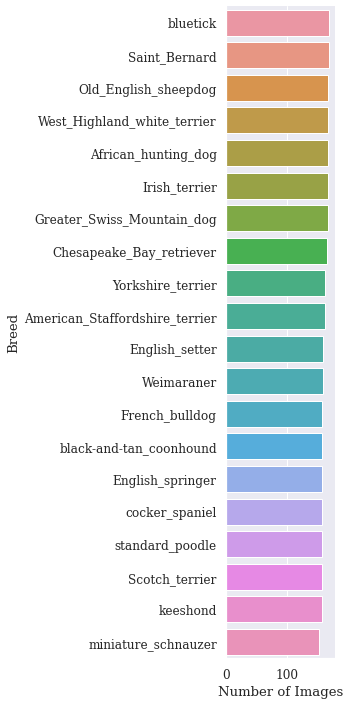

In [206]:
sns.set_theme(style="darkgrid",font_scale=1.1,font="serif")
sns.catplot(y="Breed", x="Number of Images",data=the_Selected_dogs,
            kind="bar",orient="h",height=10, aspect=0.5)

plt.show()

In [207]:
#This function performs the following actions:
#1 Reads every image from every folder of each breed
#2 Resizes the images
#3 Puts all the images and labels of each image in a numpy array

def LoadingImagesResizingAndLabels(breeds_folders,lenght,width):
    theimages=[]
    thelabels=[]
    for i, breedfolder in enumerate(breeds_folders): #names of the folders for each breed
        print(breedfolder,"...")
        for image_name in os.listdir(fpath+"/"+breedfolder): #names for each image inside the folders
            img = io.imread(fpath+"/"+breedfolder+"/"+image_name) #load image from file in RGB
            rezised=resize(img,(lenght,width)) #resizing image
            theimages.append(np.array(rezised)) #appending the images
            thelabels.append(i) #appending the labels
    imagesnp = np.array(theimages) #transforming list of images to numpy array
    labelsnp = np.array(thelabels) #transforming list of images to numpy array

    print("Number of Images:",len(imagesnp))
    print("Number of Breeds:",len(breeds_folders))
    print("Size of each image:",lenght,",",width)
    return imagesnp, labelsnp

In [208]:
#Loading the images, resizing them, and loading the labels:
lenght=224
width=224
images, labels = LoadingImagesResizingAndLabels(the_Selected_dogs["BreedsPath"],lenght,width)

n02088632-bluetick ...
n02109525-Saint_Bernard ...
n02105641-Old_English_sheepdog ...
n02098286-West_Highland_white_terrier ...
n02116738-African_hunting_dog ...
n02093991-Irish_terrier ...
n02107574-Greater_Swiss_Mountain_dog ...
n02099849-Chesapeake_Bay_retriever ...
n02094433-Yorkshire_terrier ...
n02093428-American_Staffordshire_terrier ...
n02100735-English_setter ...
n02092339-Weimaraner ...
n02108915-French_bulldog ...
n02089078-black-and-tan_coonhound ...
n02102040-English_springer ...
n02102318-cocker_spaniel ...
n02113799-standard_poodle ...
n02097298-Scotch_terrier ...
n02112350-keeshond ...
n02097047-miniature_schnauzer ...
Number of Images: 3266
Number of Breeds: 20
Size of each image: 224 , 224


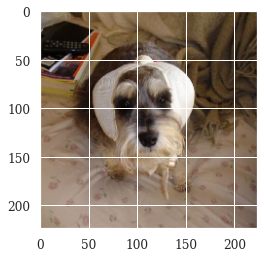

In [90]:
plt.imshow(images[-19])
plt.show()

In [209]:
#Creating a binary class matrix with the breed types:
label_output_matrix = utils.to_categorical(labels, num_classes = N_Breeds)

In [210]:
# Dividing data into training and testing (stratified)
X_train, X_test, y_train, y_test = train_test_split(images, label_output_matrix, test_size=0.2, random_state=random_seed,stratify=label_output_matrix)

#For data augmentation, we also need validation set:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed,stratify=y_train)

# from keras.utils import np_utils
print("For training without data augmentation:")
print("x_train shape = ",X_train.shape)
print("y_train shape = ",y_train.shape)

print("\nFor training with data augmentation:")
print("x_train2 shape = ",X_train2.shape)
print("y_train2 shape = ",y_train2.shape)
print("\nx_val shape = ",X_val.shape)
print("y_val shape = ",y_val.shape)

print("\nFor both cases:")
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",y_test.shape)


For training without data augmentation:
x_train shape =  (2612, 224, 224, 3)
y_train shape =  (2612, 20)

For training with data augmentation:
x_train2 shape =  (2089, 224, 224, 3)
y_train2 shape =  (2089, 20)

x_val shape =  (523, 224, 224, 3)
y_val shape =  (523, 20)

For both cases:

x_test shape =  (654, 224, 224, 3)
y_test shape =  (654, 20)


In [ ]:
# #LeNet
# model = Sequential()
# # CONV => RELU => POOL
# model.add(Conv2D(20, kernel_size=5, padding="same", input_shape=(lenght,width,3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# # CONV => RELU => POOL
# model.add(Conv2D(50, kernel_size=5, padding="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# # Flatten => RELU layers
# model.add(Flatten())
# model.add(Dense(500))
# model.add(Activation("relu"))

# # a softmax classifier
# model.add(Dense(N_Breeds))
# model.add(Activation("softmax"))

In [220]:
def AlexNet():
    #AlexNet2012
    model = Sequential()
    #1 CONV => RELU => POOL => NORMALIZATION
    model.add(Conv2D(96, kernel_size=11, padding="valid",strides=(4,4), input_shape=(lenght,width,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    #2 CONV => RELU => POOL => NORMALIZATION
    model.add(Conv2D(256, kernel_size=5, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    #3,4,5 CONV => RELU => NORMALIZATION
    model.add(Conv2D(384, kernel_size=3, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    model.add(Conv2D(384, kernel_size=3, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=3, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))

    # POOL => NORMALIZATION
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Flatten => RELU layers => Dropout => Normalization
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # Flatten => RELU layers => Dropout => Normalization
    model.add(Dense(4096))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # a softmax classifier
    model.add(Dense(N_Breeds))
    model.add(Activation("softmax"))

    #Compiling the model
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

In [221]:
def AlexNetMod1():
    #AlexNet2012
    model = Sequential()
    #1 CONV => RELU => POOL => NORMALIZATION
    model.add(Conv2D(96, kernel_size=11, padding="valid",strides=(4,4), input_shape=(lenght,width,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    # #2 CONV => RELU => POOL => NORMALIZATION
    # model.add(Conv2D(256, kernel_size=5, strides=(1,1), padding="valid"))
    # model.add(Activation("relu"))
    # model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    # model.add(BatchNormalization())

    #3,4,5 CONV => RELU => NORMALIZATION
    # model.add(Conv2D(384, kernel_size=3, strides=(1,1), padding="valid"))
    # model.add(Activation("relu"))
    # model.add(BatchNormalization())

    # model.add(Conv2D(384, kernel_size=3, strides=(1,1), padding="valid"))
    # model.add(Activation("relu"))
    # model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=3, strides=(1,1), padding="valid"))
    model.add(Activation("relu"))

    # POOL => NORMALIZATION
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    model.add(BatchNormalization())

    # Flatten => RELU layers => Dropout => Normalization
    model.add(Flatten())
    model.add(Dense(4096/4))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())


    # Flatten => RELU layers => Dropout => Normalization
    # model.add(Dense(4096/2))
    # model.add(Activation("relu"))
    # model.add(Dropout(0.5))
    # model.add(BatchNormalization())


    # a softmax classifier
    model.add(Dense(N_Breeds))
    model.add(Activation("softmax"))

    #Compiling the model
    model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

In [122]:
m=AlexNet()
m.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 activation_144 (Activation)  (None, 54, 54, 96)       0         
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 25, 25, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_126 (Ba  (None, 25, 25, 96)       384       
 tchNormalization)                                               
                                                                 
 conv2d_91 (Conv2D)          (None, 21, 21, 256)       614656    
                                                                 
 activation_145 (Activation)  (None, 21, 21, 256)    

### AlexNet Results (Without data Augmentation) batch=64

In [124]:
model1=0
history=0
model1=AlexNet()
history = model1.fit(X_train, y_train, batch_size=Batch_Size, epochs=Epochs, verbose=1, validation_split=0.2)

Epoch 1/80
25/25 [==============================] - 21s 802ms/step - loss: 3.3109 - categorical_accuracy: 0.1097 - val_loss: 2.7165 - val_categorical_accuracy: 0.0765
Epoch 2/80
25/25 [==============================] - 21s 823ms/step - loss: 2.8699 - categorical_accuracy: 0.1837 - val_loss: 2.7479 - val_categorical_accuracy: 0.0765
Epoch 3/80
25/25 [==============================] - 21s 849ms/step - loss: 2.7587 - categorical_accuracy: 0.2188 - val_loss: 2.8123 - val_categorical_accuracy: 0.0765
Epoch 4/80
14/25 [===============>..............] - ETA: 8s - loss: 2.6082 - categorical_accuracy: 0.2377

KeyboardInterrupt: 

16/16 [==============================] - 1s 81ms/step - loss: 4.5864 - categorical_accuracy: 0.2816

Test score/loss: 4.5864458084106445
Test accuracy: 0.281632661819458
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


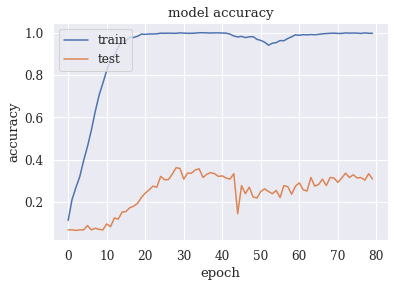

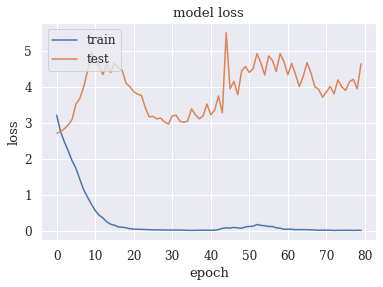

In [95]:
score = model1.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
from sklearn import metrics
label_pred = model1.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.44      0.12      0.19        34
           1       0.32      0.18      0.23        34
           2       0.64      0.26      0.37        34
           3       0.40      0.50      0.45        34
           4       0.45      0.27      0.34        33
           5       0.25      0.36      0.30        33
           6       0.56      0.15      0.24        33
           7       0.21      0.21      0.21        33
           8       0.25      0.06      0.10        32
           9       0.11      0.44      0.17        32
          10       0.25      0.22      0.23        32
          11       0.55      0.56      0.55        32
          12       0.32      0.56      0.41        32
          13       0.25      0.13      0.17        31
          14       0.22      0.19      0.21        31

    accuracy                           0.28       490
   macro avg       0.35      0.28      0.28       490
weighted avg       0.35   

The model is overfitted

### AlexNet Results (With data augmentation) batch=64

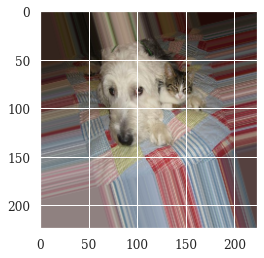

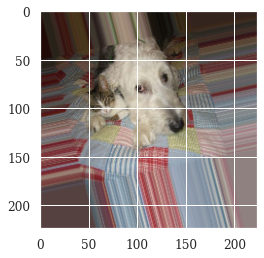

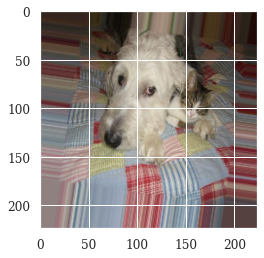

In [125]:
# From https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# To try to see the data generator effects
# example:
from numpy import expand_dims

from keras.preprocessing.image import ImageDataGenerator

data = images[1]

#expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,fill_mode="nearest",shear_range=0.1,
							horizontal_flip=True,rotation_range=30,zoom_range=[1.2,1.7])


# prepare iterator
it = datagen.flow(samples, batch_size=64)
# generate samples and plot
for i in range(3):
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0]
	# plot raw pixel data
	plt.imshow(image)
	# show the figure
	plt.show()

In [130]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen_train = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,fill_mode="nearest",shear_range=0.1,
							horizontal_flip=True,rotation_range=20,zoom_range=[1,1.5])

datagen_val = ImageDataGenerator(width_shift_range=0.05,height_shift_range=0.05,fill_mode="nearest",shear_range=0.05,
							horizontal_flip=True,rotation_range=20,zoom_range=[1,1.3])
# create the iterator
it_train = datagen_train.flow(X_train2,y_train2,batch_size=Batch_Size,shuffle=True)
it_val = datagen_val.flow(X_val,y_val,batch_size=Batch_Size,shuffle=True)

#step_per_epoch_train=int(len(X_train)/Batch_Size) #Num of batches of samples comprising one epoch

step_per_epoch_test=int(len(X_test)/Batch_Size) #Num of batches of samples comprising one epoch

step_per_epoch_train=25


In [131]:
model2=0 #to reset
history=0 #to reset

In [132]:
model2=AlexNet()
history = model2.fit(it_train,
                    steps_per_epoch=step_per_epoch_train, 
                    batch_size=Batch_Size, 
                    epochs=Epochs, 
                    verbose=1,
                    validation_data=it_val,
                    validation_steps=step_per_epoch_test,
                    shuffle=True)

Epoch 1/80
25/25 [==============================] - 27s 1s/step - loss: 3.3531 - categorical_accuracy: 0.1040 - val_loss: 2.7228 - val_categorical_accuracy: 0.0689
Epoch 2/80
25/25 [==============================] - 28s 1s/step - loss: 3.0798 - categorical_accuracy: 0.1626 - val_loss: 2.7684 - val_categorical_accuracy: 0.0689
Epoch 3/80
25/25 [==============================] - 27s 1s/step - loss: 3.0145 - categorical_accuracy: 0.1588 - val_loss: 2.8277 - val_categorical_accuracy: 0.0689
Epoch 4/80
25/25 [==============================] - 28s 1s/step - loss: 2.9975 - categorical_accuracy: 0.1767 - val_loss: 2.9382 - val_categorical_accuracy: 0.0689
Epoch 5/80
25/25 [==============================] - 27s 1s/step - loss: 2.9070 - categorical_accuracy: 0.1945 - val_loss: 3.0709 - val_categorical_accuracy: 0.0689
Epoch 6/80
25/25 [==============================] - 28s 1s/step - loss: 2.8694 - categorical_accuracy: 0.1977 - val_loss: 3.1674 - val_categorical_accuracy: 0.0740
Epoch 7/80
25/25

KeyboardInterrupt: 

16/16 [==============================] - 1s 78ms/step - loss: 3.1102 - categorical_accuracy: 0.3898

Test score/loss: 3.1102447509765625
Test accuracy: 0.3897959291934967
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


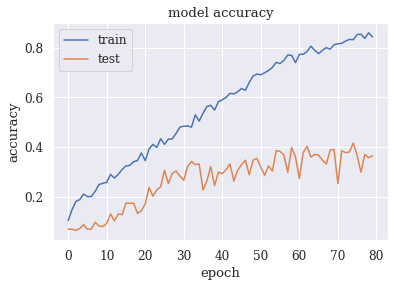

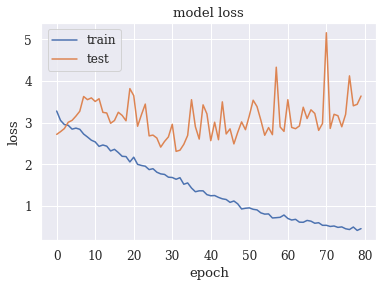

In [107]:
score = model2.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
from sklearn import metrics
label_pred = model2.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.70      0.21      0.32        34
           1       0.44      0.50      0.47        34
           2       0.52      0.47      0.49        34
           3       0.58      0.56      0.57        34
           4       0.71      0.67      0.69        33
           5       0.50      0.21      0.30        33
           6       0.37      0.64      0.47        33
           7       0.17      0.18      0.17        33
           8       0.14      0.22      0.17        32
           9       0.33      0.28      0.31        32
          10       0.29      0.25      0.27        32
          11       0.73      0.59      0.66        32
          12       0.54      0.59      0.57        32
          13       0.24      0.26      0.25        31
          14       0.15      0.19      0.17        31

    accuracy                           0.39       490
   macro avg       0.43      0.39      0.39       490
weighted avg       0.43   

### AlexNet Results (Without data Augmentation) batch=32

In [109]:
model3=0 #to reset
history=0 #to reset
model3=AlexNet()
history = model3.fit(X_train, y_train, batch_size=32, epochs=Epochs, verbose=1, validation_split=0.2)

Epoch 1/80
49/49 [==============================] - 26s 506ms/step - loss: 3.2800 - categorical_accuracy: 0.1307 - val_loss: 2.7564 - val_categorical_accuracy: 0.0842
Epoch 2/80
49/49 [==============================] - 26s 526ms/step - loss: 2.9237 - categorical_accuracy: 0.1958 - val_loss: 2.8223 - val_categorical_accuracy: 0.0740
Epoch 3/80
49/49 [==============================] - 28s 562ms/step - loss: 2.7059 - categorical_accuracy: 0.2232 - val_loss: 3.1315 - val_categorical_accuracy: 0.0765
Epoch 4/80
49/49 [==============================] - 26s 527ms/step - loss: 2.6138 - categorical_accuracy: 0.2404 - val_loss: 3.2566 - val_categorical_accuracy: 0.0663
Epoch 5/80
49/49 [==============================] - 26s 525ms/step - loss: 2.3363 - categorical_accuracy: 0.3048 - val_loss: 3.4540 - val_categorical_accuracy: 0.0816
Epoch 6/80
49/49 [==============================] - 26s 533ms/step - loss: 2.1341 - categorical_accuracy: 0.3546 - val_loss: 3.3596 - val_categorical_accuracy: 0.107

KeyboardInterrupt: 

In [113]:
score = model3.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from sklearn import metrics
label_pred = model3.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

16/16 [==============================] - 1s 85ms/step - loss: 3.0079 - categorical_accuracy: 0.2612

Test score/loss: 3.007935047149658
Test accuracy: 0.2612244784832001


AttributeError: 'int' object has no attribute 'history'

### AlexNet Results (With data augmentation) batch=32

In [222]:
from keras.preprocessing.image import ImageDataGenerator
# create image data augmentation generator
datagen_train = ImageDataGenerator(horizontal_flip=True,rotation_range=30,zoom_range=[1,1.5])

datagen_val = ImageDataGenerator(horizontal_flip=True,rotation_range=10,zoom_range=[1,1.2])

# datagen_train = ImageDataGenerator(width_shift_range=0.15,height_shift_range=0.15,fill_mode="nearest",shear_range=0.1,
# 							horizontal_flip=True,rotation_range=30,zoom_range=[1,1.5])

# datagen_val = ImageDataGenerator(width_shift_range=0.01,height_shift_range=0.01,fill_mode="nearest",shear_range=0.05,
# 							horizontal_flip=True,rotation_range=10,zoom_range=[1,1.2])
# create the iterator
it_train = datagen_train.flow(X_train2,y_train2,batch_size=32,shuffle=True)
it_val = datagen_val.flow(X_val,y_val,batch_size=32,shuffle=True)

#step_per_epoch_train=int(len(X_train)/Batch_Size) #Num of batches of samples comprising one epoch

step_per_epoch_test=int(len(X_test)/Batch_Size) #Num of batches of samples comprising one epoch

step_per_epoch_train=65

In [223]:
model4=0
history=0

In [224]:
model4=0
history=0
model4=AlexNet()
history = model4.fit(it_train,
                    steps_per_epoch=step_per_epoch_train, 
                    batch_size=32, 
                    epochs=Epochs, 
                    verbose=1,
                    validation_data=it_val,
                    validation_steps=step_per_epoch_test)
# history = model4.fit(it_train,steps_per_epoch=step_per_epoch_train, batch_size=32, epochs=Epochs, verbose=1,validation_data=(X_val, y_val))

Epoch 1/80
65/65 [==============================] - 45s 672ms/step - loss: 4.2359 - categorical_accuracy: 0.0895 - val_loss: 102.7583 - val_categorical_accuracy: 0.0625
Epoch 2/80
65/65 [==============================] - 42s 642ms/step - loss: 3.6332 - categorical_accuracy: 0.1108 - val_loss: 6.1047 - val_categorical_accuracy: 0.1000
Epoch 3/80
65/65 [==============================] - 44s 673ms/step - loss: 3.5870 - categorical_accuracy: 0.1245 - val_loss: 6.3215 - val_categorical_accuracy: 0.1125
Epoch 4/80
65/65 [==============================] - 43s 661ms/step - loss: 3.4597 - categorical_accuracy: 0.1381 - val_loss: 4.8196 - val_categorical_accuracy: 0.0938
Epoch 5/80
65/65 [==============================] - 41s 635ms/step - loss: 3.4723 - categorical_accuracy: 0.1342 - val_loss: 5.7130 - val_categorical_accuracy: 0.1000
Epoch 6/80
65/65 [==============================] - 41s 633ms/step - loss: 3.3533 - categorical_accuracy: 0.1473 - val_loss: 4.4779 - val_categorical_accuracy: 0.1

(224, 224, 3)

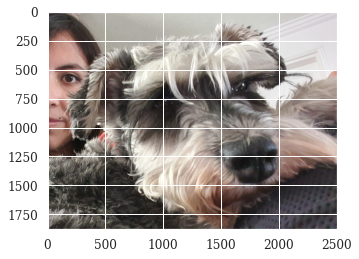

In [233]:
#score = model4.evaluate(X_test, y_test, verbose=1)
img = io.imread("C:/Users/gabri/Pictures/2021-07-17 09.34.47.jpg") #load image from file in RGB
plt.imshow(img)
rezisedi=resize(img,(lenght,width)) #resizing image
im=np.array(rezisedi) #appending the images
im.shape

In [240]:
a=im.reshape(1,224,224,3)
a.shape
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [241]:
pred=model4.predict(a)


In [242]:
pred

array([[0.000025, 0.000005, 0.000088, 0.000001, 0.000074, 0.000001,
        0.000000, 0.000000, 0.000000, 0.000395, 0.000515, 0.000073,
        0.044421, 0.000004, 0.000006, 0.000033, 0.000262, 0.000001,
        0.005790, 0.948306]], dtype=float32)

21/21 [==============================] - 2s 87ms/step - loss: 4.0134 - categorical_accuracy: 0.3196

Test score/loss: 4.013368606567383
Test accuracy: 0.319571852684021
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


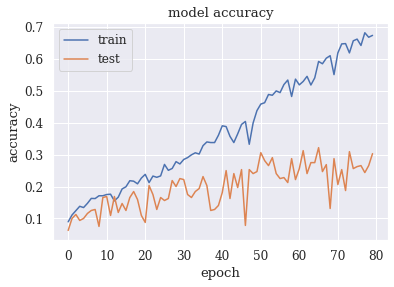

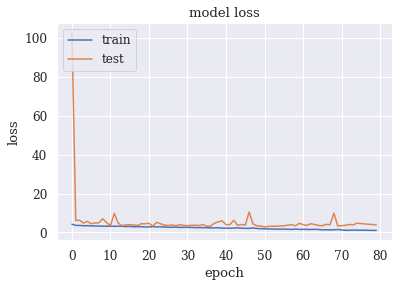

              precision    recall  f1-score   support

           0       0.32      0.24      0.27        34
           1       0.65      0.32      0.43        34
           2       0.34      0.32      0.33        34
           3       0.44      0.50      0.47        34
           4       0.45      0.53      0.49        34
           5       0.37      0.50      0.42        34
           6       0.52      0.41      0.46        34
           7       0.40      0.18      0.25        33
           8       0.22      0.33      0.27        33
           9       0.27      0.09      0.14        33
          10       0.11      0.09      0.10        32
          11       0.26      0.19      0.22        32
          12       0.23      0.09      0.13        32
          13       0.33      0.53      0.40        32
          14       0.38      0.41      0.39        32
          15       0.16      0.28      0.20        32
          16       0.15      0.28      0.20        32
          17       0.30    

In [225]:
score = model4.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from sklearn import metrics
label_pred = model4.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

### Inception V3 

In [99]:
#The structure of Inception V3 architecture is imported
#We will include the weights of the already trained model on ImageNet.

ResNet50V2m=0
#ResNet50V2m=applications.ResNet50V2(weights= 'imagenet')
ResNet50V2m=applications.ResNet50V2()
ResNet50V2m.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_31[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [117]:
model5 = Sequential()

# for layer in ResNet50V2m.layers:
#     #layer.trainable= False
#     print(layer,layer.trainable)

# a softmax classifier


model5.add(ResNet50V2m)
model5.add(Dropout(0.2))
model5.add(Dense(N_Breeds))
model5.add(Activation("softmax"))

In [118]:
model5.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model5.fit(X_train, y_train, batch_size=Batch_Size, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
33/33 [==============================] - 304s 9s/step - loss: 2.9959 - categorical_accuracy: 0.0503 - val_loss: 2.9970 - val_categorical_accuracy: 0.0421
Epoch 2/100
33/33 [==============================] - 259s 8s/step - loss: 2.9958 - categorical_accuracy: 0.0402 - val_loss: 2.9969 - val_categorical_accuracy: 0.0421
Epoch 3/100
33/33 [==============================] - 255s 8s/step - loss: 2.9947 - categorical_accuracy: 0.0503 - val_loss: 2.9952 - val_categorical_accuracy: 0.0344
Epoch 4/100
33/33 [==============================] - 284s 9s/step - loss: 2.9925 - categorical_accuracy: 0.0608 - val_loss: 2.9929 - val_categorical_accuracy: 0.0727
Epoch 5/100
33/33 [==============================] - 266s 8s/step - loss: 2.9876 - categorical_accuracy: 0.0699 - val_loss: 2.9977 - val_categorical_accuracy: 0.0516
Epoch 6/100
33/33 [==============================] - 285s 9s/step - loss: 2.9812 - categorical_accuracy: 0.0804 - val_loss: 2.9997 - val_categorical_accuracy: 0.0497
Epoc

21/21 [==============================] - 17s 826ms/step - loss: 2.6539 - categorical_accuracy: 0.1865

Test score/loss: 2.65385365486145
Test accuracy: 0.18654434382915497
dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


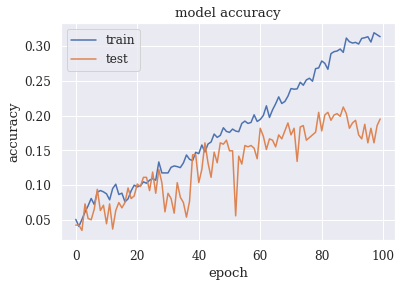

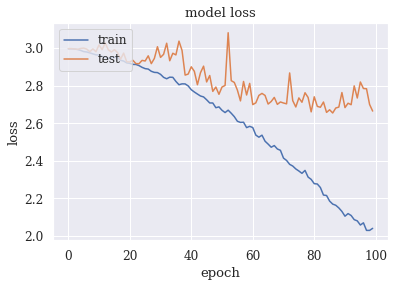

              precision    recall  f1-score   support

           0       0.07      0.18      0.10        34
           1       0.14      0.41      0.21        34
           2       0.00      0.00      0.00        34
           3       0.08      0.03      0.04        34
           4       0.32      0.47      0.38        34
           5       0.24      0.71      0.36        34
           6       0.15      0.06      0.09        34
           7       0.20      0.06      0.09        33
           8       0.17      0.03      0.05        33
           9       0.00      0.00      0.00        33
          10       0.15      0.06      0.09        32
          11       0.13      0.34      0.19        32
          12       0.20      0.03      0.05        32
          13       0.32      0.38      0.35        32
          14       0.17      0.09      0.12        32
          15       0.00      0.00      0.00        32
          16       0.00      0.00      0.00        32
          17       0.35    

In [119]:
score = model5.evaluate(X_test, y_test, verbose=1)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from sklearn import metrics
label_pred = model5.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

In [75]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

modelX = ResNet50(weights='imagenet')

img_path = 'C:/Users/gabri/Pictures/UNSCH.jpg'
img = image.load_img(img_path, target_size=(224, 224))
A = image.img_to_array(img)
B = np.expand_dims(A, axis=0)
x = preprocess_input(B)

preds = modelX.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=5)[0])

Predicted: [('n02097047', 'miniature_schnauzer', 0.9138423), ('n02097209', 'standard_schnauzer', 0.067116186), ('n02097130', 'giant_schnauzer', 0.014285855), ('n02097298', 'Scotch_terrier', 0.0029934642), ('n02093859', 'Kerry_blue_terrier', 0.0003439624)]


In [76]:

from sklearn import metrics
label_pred = modelX.predict(X_test)
pred = []

for i in range(len(label_pred)):
    pred.append(np.argmax(label_pred[i]))

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index


print(metrics.classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      34.0
           1       0.00      0.00      0.00      34.0
           2       0.00      0.00      0.00      34.0
           3       0.00      0.00      0.00      34.0
           4       0.00      0.00      0.00      34.0
           5       0.00      0.00      0.00      34.0
           6       0.00      0.00      0.00      34.0
           7       0.00      0.00      0.00      33.0
           8       0.00      0.00      0.00      33.0
           9       0.00      0.00      0.00      33.0
          10       0.00      0.00      0.00      32.0
          11       0.00      0.00      0.00      32.0
          12       0.00      0.00      0.00      32.0
          13       0.00      0.00      0.00      32.0
          14       0.00      0.00      0.00      32.0
          15       0.00      0.00      0.00      32.0
          16       0.00      0.00      0.00      32.0
          17       0.00    

C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [ ]:
history = InceptionV3.fit(X_train, y_train, batch_size=Batch_Size, epochs=Epochs, verbose=1, validation_split=0.2)
